## 10. 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge
- 일본의 대형 온라인 쇼핑몰인 Mercari사의 제품에 대해 가격을 예측하는 과제
- 제공되는 데이터 세트는 제품에 대한 여러 속성 및 제품 설명 등의 텍스트 데이터로 구성됨

- 데이터 세트 : [Mercari](http://www.kaggle.com/c/mercari-price-suggestion-challenge/data)

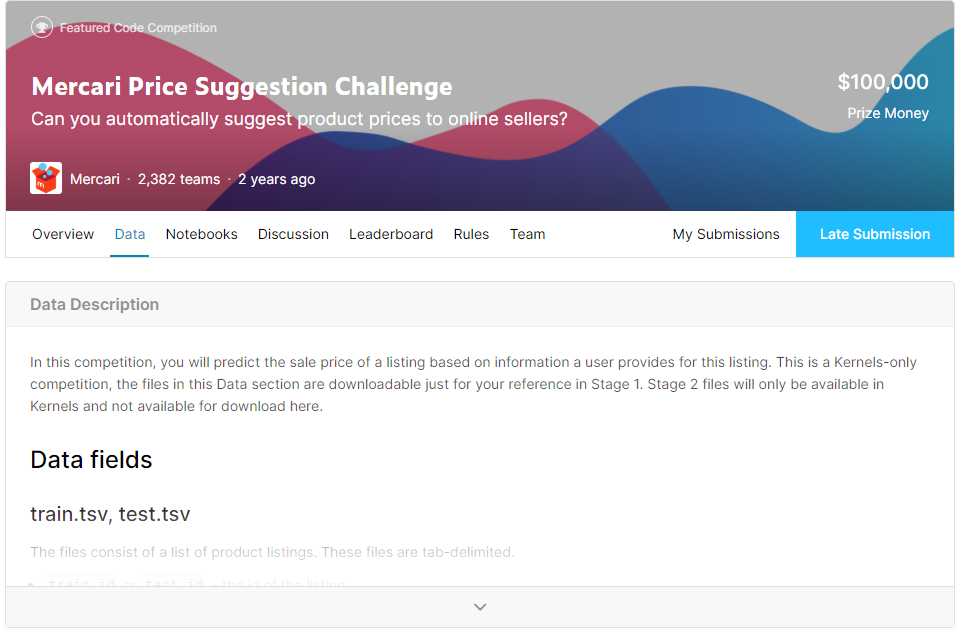

### 제공되는 데이터 세트의 속성

|데이터|속성|
|------|----|
|train_id|데이터 id|
|name|제품명|
|item_condition_id|판매자가 제공하는 제품 상태|
|category_name|카테고리 명|
|brand_name|브랜드 이름|
|price|제품 가격, 예측을 위한 타깃 속성|
|shipping|배송비 무료 여부. 1이면 무료, 0이면 유료|
|item_description|제품에 대한 설명(다섯 가지 유형으로 표현. 1,2,3,4,5)|

### 데이터 전처리

In [2]:
from sklearn.linear_model import Ridge , LogisticRegression
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
import pandas as pd

mercari_df= pd.read_csv('./mercari-price-suggestion-challenge/train.tsv',sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


train_id                                 name  item_condition_id  \
0         0  MLB Cincinnati Reds T Shirt Size XL                  3   
1         1     Razer BlackWidow Chroma Keyboard                  3   
2         2                       AVA-VIV Blouse                  1   

                                       category_name brand_name  price  \
0                                  Men/Tops/T-shirts        NaN   10.0   
1  Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                        Women/Tops & Blouses/Blouse     Target   10.0   

   shipping                                   item_description  
0         1                                 No description yet  
1         0  This keyboard is in great condition and works ...  
2         1  Adorable top with a hint of lace and a key hol...

#### 피처의 타입과 Null 여부 확인

In [3]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


#### Null 값들 크기 보기
- 3군데에서 null값 발견
- 특히 brand_name에 많은 null 값이 있고 category_name도 적당히 있음
- item_description은 4개라는 적은 null 값들이 있음
- 나중에 이 값들을 치환한다고 함

In [4]:
mercari_df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

### 데이터 클렌징 작업

#### Target 값인 Price 칼럼의 데이터 분포도

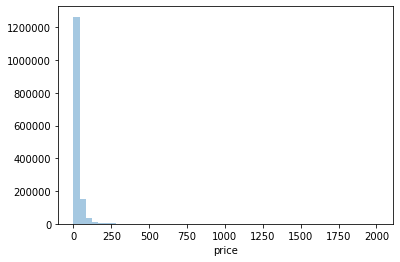

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df,kde=False)

- price 값이 비교적 적은 가격을 가진 데이터 값에 왜곡돼 분포돼 있음
  - price 칼럼을 로그 값으로 변환

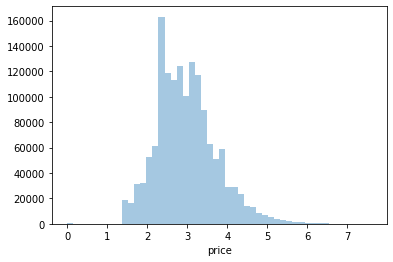

In [6]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df,kde=False)

In [7]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

#### 다른 피처의 값 살피기
- shipping 값은 비교적 균형함
- item_condition_id는 4,5 값이 상대적으로 적음

In [8]:
print('Shipping 값 유형:\n',mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n',mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


- item_description에서는 한 개의 문자열이 압도적으로 많음

In [11]:
mercari_df['item_description'].value_counts()

No description yet                                                                                                                                                                                                                                                                                                                                                                                                                                                         82489
New                                                                                                                                                                                                                                                                                                                                                                                                                                                                         4099
Brand new                                                             

In [12]:
boolean_cond= mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

- item_description에서 No description yet이 압독적으로 많음
  - 2번째로 많은 단어가 New인데 4099 <<<< No description yet은 82489
- 한쪽으로 치우쳐 있으면 회귀 분석에서 좋은 결과가 나올 수 없음
  - 왜 안 좋은지 예를 들면
    - 은행 사기 사건이 매일 일어나지 않고 10달에 한 번씩 일어난다고 가정하면
    - 해당 데이터로 학습 시키면 사기 사건 일어난 건수가 적어서 그 특징을 뽑지 못해 제대로 예측하기 힘듬
    - 그래서 예측할 시 사기 사건이 아니다라는 것으로 예측해버리고 test에서도 사기 사건이 적으니 예측률은 높지만 좋은 모델이 나올 수 없어짐
  - 이런 사태를 방지하기 위해 적절한 값으로 변경해야 함

- category_name
  - '/'로 분리된 카테고리를 하나의 문장려로 나타내고 있음

In [13]:
mercari_df['category_name'][:5]

0                                    Men/Tops/T-shirts
1    Electronics/Computers & Tablets/Components & P...
2                          Women/Tops & Blouses/Blouse
3                   Home/Home Décor/Home Décor Accents
4                              Women/Jewelry/Necklaces
Name: category_name, dtype: object

- ex)Men/Tops/T-shirts면 대분류 'Men', 중분류 'Tops', 소분류 'T-shirts'로 나눌 수 있음
- category_name이 텍스트이므로 피처 추출 시 tokenizer를 '/'로 하여 단어를 분리해 벡터화할 수 있음
- 저자는 split_cat() 함수를 생성했다고 함

In [14]:
# apply lambda에서 호출되는 대,중,소 분할 함수 생성, 대,중,소 값을 리스트 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null' , 'Other_Null' , 'Other_Null']

# 위의 split_cat( )을 apply lambda에서 호출하여 대,중,소 컬럼을 mercari_df에 생성. 
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
                        zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 갯수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 갯수 :', mercari_df['cat_jung'].nunique())
print('소분류 갯수 :', mercari_df['cat_so'].nunique())

대분류 유형 :
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 갯수 : 114
소분류 갯수 : 871


- brand_name,category_name,item_description 칼럼은 Null 값은 일괄적으로 'Other Null'로 동일하게 변경하겠다고 합니다.

In [15]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 컬럼별로 Null값 건수 확인. 모두 0가 나와야 합니다.
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

### 피처 인코딩과 피처 벡터화
- 문자열 칼럼이 많으므로 레이블 또는 원-핫 인코딩을 수행하거나 피처 벡터화로 변환할 칼럼을 선별하겠다고 합니다.
- 선형 회귀 모델과 회귀 트리 모델을 모두 적용할 예정인데 선형 회귀에서는 원-핫 인코딩 적용이 훨씬 선호되어서 인코딩할 피처를 모두 원-핫 인코딩으로 적용하겠다고 합니다.
  - 비교적 짧은 텍스트의 경우 -> Count 기반의 벡터화
  - 긴 텍스트의 경우 -> TF-IDF 기반의 벡터화

#### brand_name 검토

In [16]:
print('brand name 의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

brand name 의 유형 건수 : 4810
brand name sample 5건 : 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


- brand_name의 경우 대부분 명료한 문자열로 돼 있음
  - 별도의 피처 벡터화 형태로 만들 필요 없이 인코딩 변환을 적용하면 됨
  - 열이 4810 더 생기는데 행이 1482535 이므로 딱히 문제가 되지 않음

#### name 검토

In [17]:
print('name 의 종류 갯수 :', mercari_df['name'].nunique())
# df.nunique() : 유일한 값의 개수가 몇 개인지 알려주는 함수
print('name sample 7건 : \n', mercari_df['name'][:7])

name 의 종류 갯수 : 1225273
name sample 7건 : 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


In [22]:
test1=mercari_df['name'].value_counts().reset_index()
print(len(test1[test1['name']==1]))
print(len(test1[test1['name']>1]))
print(mercari_df.shape)

1142007
83266
(1482535, 11)


In [24]:
print('name 평균 문자열 개수:',mercari_df['name'].str.len().mean())

name 평균 문자열 개수: 25.78639762299035


- name의 경우 종류가 매우 많음
  - 거의 고유한 상품명을 가지고 있음
  - 적은 단어 위주의 텍스트 형태로 돼 있어서 Count 기반으로 피처 벡터화 변환을 적용하겠다고 합니다.

#### category_name, shipping, item_condition_id
- 모두 원-핫 인코딩 적용

#### item_description
- 상품에 대한 간단 설명으로 데이터 세트에서 가장 긴 텍스트를 가지고 있음

In [23]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 개수
print('item_description 평균 문자열 개수:',mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 개수: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

- 평균 문자열이 145자로 비교적 크므로 해당 칼럼은 TF-IDF로 변환하겠음

#### 인코딩 및 피처 벡터화 변환 총 정리
1. name : CountVectorizer로 변환(기본 파라미터)
2. item_description : TfidVectorizer로 변환(max_features=50000, n_gram_range=(1,3), stop_words는 english로 설정)

In [25]:
# name 속성에 대한 feature vectorization 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description 에 대한 feature vectorization 변환 
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range= (1,3) , stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:',X_name.shape)
print('item_description vectorization shape:',X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


- CountVectorizer, TfidVectorizer가 fit_transform()을 통해 반환하는 데이터는 희소 행렬 형태임
  - 저자는 희소 행렬 객체 변수인 X_name과 X_descp를 결합 -> 새로운 데이터 세트로 구성
  - 원-핫 인코딩할 다른 변수들도 X_name과 X_descp와 결합해 ML 모델을 실행하는 기반 데이터 세트로 재구성한다고 합니다.
- 이를 위해 이 인코딩 대상 칼럼도 밀집 행렬 행태가 아닌 희소 행렬 형태로 인코딩을 적용한 뒤, 함께 결합하도록 하겠다고 합니다.

### 사이킷런의 원-핫 인코딩 제공 방식
1. OneHotEncoder 
2. LabelBinarizer : 희소 행렬 형태의 원-핫 인코딩 변환을 지원한다고 합니다.

- 잘 모르겠지만 OneHotEncoder에서도 sparse를 지원해줍니다. 한 번 실행해보니 비슷한 결과가 나와서 과연 차이가 있는지 잘 모르겠습니다.
- 그나마 차이점이라면 OneHotEncoder는 변환 시 array로 변환하고 LabelBinarizer는 변환 시 csr로 변환한다고 합니다.

In [37]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

mercari_df2=mercari_df.copy()
mercari_df3=mercari_df.copy()
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df2['item_condition_id'])
print(X_item_cond_id)

lb_item_cond_id2= OneHotEncoder(sparse=True)
X_item_cond_id2 = lb_item_cond_id2.fit_transform(pd.DataFrame(mercari_df3['item_condition_id']))
print(X_item_cond_id2)

  (0, 2)	1
  (1, 2)	1
  (2, 0)	1
  (3, 0)	1
  (4, 0)	1
  (5, 2)	1
  (6, 2)	1
  (7, 2)	1
  (8, 2)	1
  (9, 2)	1
  (10, 1)	1
  (11, 0)	1
  (12, 1)	1
  (13, 0)	1
  (14, 2)	1
  (15, 0)	1
  (16, 0)	1
  (17, 0)	1
  (18, 0)	1
  (19, 1)	1
  (20, 2)	1
  (21, 0)	1
  (22, 2)	1
  (23, 0)	1
  (24, 1)	1
  :	:
  (1482510, 0)	1
  (1482511, 0)	1
  (1482512, 1)	1
  (1482513, 2)	1
  (1482514, 2)	1
  (1482515, 2)	1
  (1482516, 0)	1
  (1482517, 2)	1
  (1482518, 2)	1
  (1482519, 0)	1
  (1482520, 2)	1
  (1482521, 0)	1
  (1482522, 0)	1
  (1482523, 2)	1
  (1482524, 1)	1
  (1482525, 1)	1
  (1482526, 1)	1
  (1482527, 0)	1
  (1482528, 1)	1
  (1482529, 1)	1
  (1482530, 1)	1
  (1482531, 1)	1
  (1482532, 1)	1
  (1482533, 2)	1
  (1482534, 0)	1


C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


  (0, 2)	1.0
  (1, 2)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (4, 0)	1.0
  (5, 2)	1.0
  (6, 2)	1.0
  (7, 2)	1.0
  (8, 2)	1.0
  (9, 2)	1.0
  (10, 1)	1.0
  (11, 0)	1.0
  (12, 1)	1.0
  (13, 0)	1.0
  (14, 2)	1.0
  (15, 0)	1.0
  (16, 0)	1.0
  (17, 0)	1.0
  (18, 0)	1.0
  (19, 1)	1.0
  (20, 2)	1.0
  (21, 0)	1.0
  (22, 2)	1.0
  (23, 0)	1.0
  (24, 1)	1.0
  :	:
  (1482510, 0)	1.0
  (1482511, 0)	1.0
  (1482512, 1)	1.0
  (1482513, 2)	1.0
  (1482514, 2)	1.0
  (1482515, 2)	1.0
  (1482516, 0)	1.0
  (1482517, 2)	1.0
  (1482518, 2)	1.0
  (1482519, 0)	1.0
  (1482520, 2)	1.0
  (1482521, 0)	1.0
  (1482522, 0)	1.0
  (1482523, 2)	1.0
  (1482524, 1)	1.0
  (1482525, 1)	1.0
  (1482526, 1)	1.0
  (1482527, 0)	1.0
  (1482528, 1)	1.0
  (1482529, 1)	1.0
  (1482530, 1)	1.0
  (1482531, 1)	1.0
  (1482532, 1)	1.0
  (1482533, 2)	1.0
  (1482534, 0)	1.0


In [38]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name= LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [39]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand_shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


- 열이 엄청 많이 생겼지만 행이 많으므로 딱히 상관 없음
  - 행이 적으면 저런 짓 하면 안됩니다...
- 앞에서 피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트를 sparse의 hstack()을 이용해 모두 결합한다고 합니다.
  - 결합하면 많음 메모리를 잡아먹어서 추후에 모델 적용할 때마다 다시 결합해 해당 데이터 세트를 이용하겠다고 합니다.

### gc란?
- 파이썬의 메모리 관리 관련 방식이라고 합니다.
- 파이썬의 메모리 할당과 해제는 자동으로 이뤄집니다.
- 메모리 할당을 위해서 reference couning과 garbage collection 두가지 방식을 사용합니다.
  - rc
    - 시스템에서 어떠한 객체에 다른 객체의 참조의 개수를 통해 동작함
    - 주의 사항
      - 자기자신을 참조하는 객체는 관리할 수 없다고 합니다.
- 이정도만 알지 않으면 되지 않을까 싶습니다.
  - 물론 나중에 엄청 큰 데이터로 깊은 층의 딥러닝을 돌리면 이것을 신경써야 하긴 하지만 지금은 그정도가 아니기 때문에.... 괜찮지 않을까 싶습니다 

### gc 추가 설명
- 파이썬에선 기본적으로 garbage collection(gc)과 reference counting(rc)을 통해 할당된 메모리를 관리합니다.
- rc : 기본적으로 참조 횟수가 0이 된 객체를 메모리에서 해제
  - 참조 횟수란? [위키백과 들어가서 보세요!](https://ko.wikipedia.org/wiki/%EC%B0%B8%EC%A1%B0_%ED%9A%9F%EC%88%98_%EA%B3%84%EC%82%B0_%EB%B0%A9%EC%8B%9D)
- gc : rc가 0인 경우가 없긴 하지만 0인 경우에 처리하지 못하는 순환 참조가 발생했을 때는 gc로 그 상황을 해결함
  - 순환 참조 : 서로 다른 객체들 사이에 참조 방식이 순환 형태로 연결되는 방식
  
- 자세히 설명해주신 티스토리 글이 있어서 링크 올립니다!
[gc,rc 설명](https://ecycle.tistory.com/27)

### 릿지 회귀 모델 구축 및 평가
- 수행에 필요한 로직을 함수화하겠다고 합니다.
- 모델을 평가하는 평가로직을 함수화하겠다고 합니다.
- 적용할 평가 지표 : RMSLE
  - RMSLE : RMSE와 유사하나 오류 값에 로그를 취해 RMSE를 구하는 방식
  - 낮은 가격보다 높은 가격에서 오류가 발생할 경우 오류 값이 더 커지는 것을 억제하기 위해서 이 방식을 도입했음
  
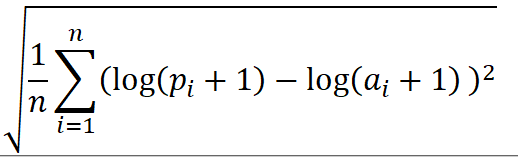

- 주의해야할 사항 : 예전에 price 값을 정규 분포 형태로 바꾸기 위해 로그 값을 취한 적이 있음
  - 평가를 로그로 하기 때문에 미리 적용할 필요가 없으므로 다시 돌리는 작업이 필요하다

In [40]:
def rmsle(y , y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산 
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test , preds): 
    
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요. 
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

- 학습용 데이터를 생성하고 모델을 학습/ 예측하는 로직을 별도의 함수로 만들겠다고 합니다.(위에서 언급한 대로 메모리 문제 때문에)

In [41]:
import gc 
from  scipy.sparse import hstack

def model_train_predict(model,matrix_list):
    # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
    X= hstack(matrix_list).tocsr()     
    
    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], 
                                                      test_size=0.2, random_state=156)
    
    # 모델 학습 및 예측
    model.fit(X_train , y_train)
    preds = model.predict(X_test)
    
    del X , X_train , X_test , y_train 
    gc.collect()
    
    return preds , y_test

- 이 함수를 사용하여 Ridge를 이용해 Mercari Price의 회귀 예측을 수행
  - item_description과 같은 텍스트 형태의 속성이 얼마나 영향을 미치는지 알아보기 위해 포함 여부 유무에 따라 예측 성능을 테스트했다고 합니다.

In [42]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.5021632139113014
Item Description을 포함한 rmsle 값: 0.4712204327749622


### LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가
- 먼저 LightGBM으로 회귀 수행
  - n_estimator=1000 이상 증가시키면 예측 성능은 조금 좋아지지만 수행 시간이 PC에서 1시간 이상이 걸림
  - 이 때문에 n_estimator=200으로 작게 설정하고 예측 성능을 측정하겠다고 합니다.

In [43]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

LightGBM rmsle 값: 0.4573536578900436


- 앞 예제의 Ridge보다 예측 성능이 더 나아졌다고 합니다.
- Ridge와 LightGBM, 이 둘로 서로 앙상블해서 최종 예측 결과값을 도출하겠다고 합니다.
  - 배합 비율은 임의로 산정했다고 합니다.

In [44]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.4507099676291016
